In [1]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'/usr/local/bin/tesseract'

from PIL import Image

import pandas as pd

import re

import warnings
warnings.filterwarnings('ignore')

In [2]:
rooms_set = {"DINING ROOM", "KITCHEN", "LIVING ROOM", 
             "BEDROOM 1", "BEDROOM 2", "BEDROOM 3", "BEDROOM 4", "GARAGE", 
             "MASTER BEDROOM", "SITTING ROOM", "UTILITY", "CONSERVATORY", "RECEPTION ROOM", "GARDEN",
            "STUDY"}

In [3]:
room_side_regex = r'[0-9]+[.][0-9]+'

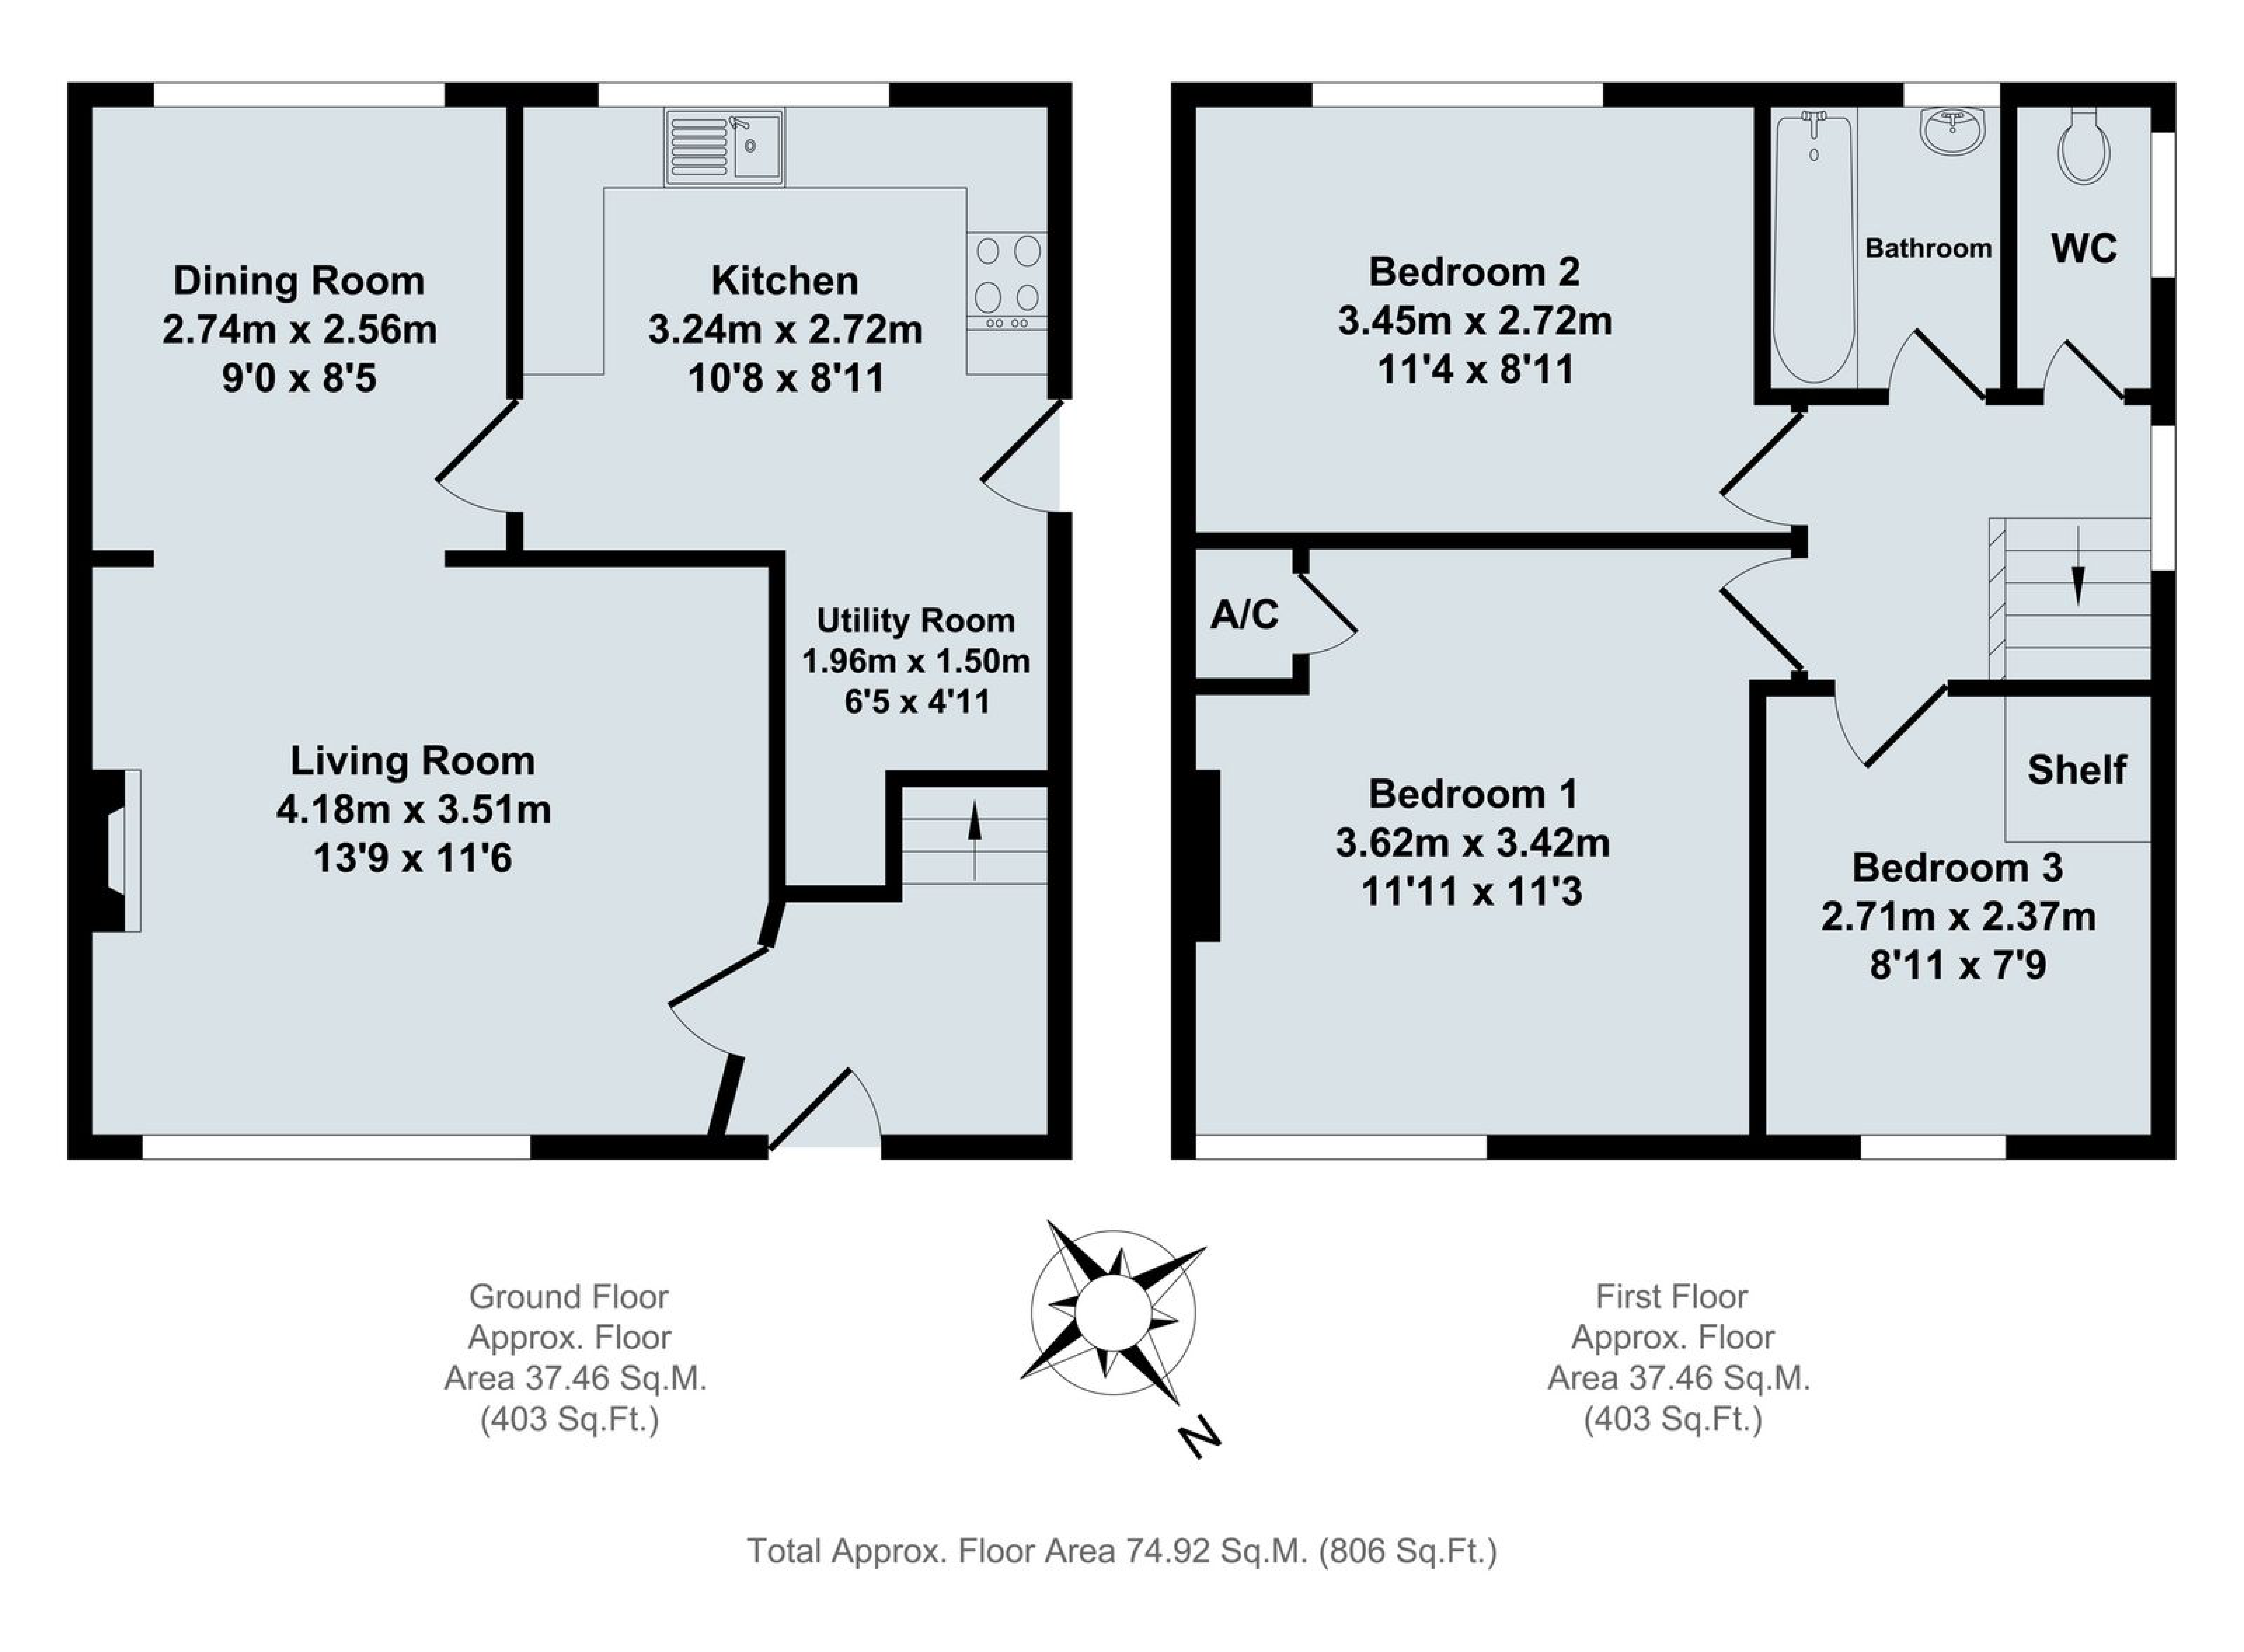

In [4]:
image = Image.open('plans/floorplan_01.jpeg')
image = image.resize((image.size[0] * 4, image.size[1] * 4))
image

In [5]:
df = pytesseract.image_to_data(image, output_type='data.frame')
df = df[df['conf'] != -1]
df['text'] = df['text'].apply(lambda x: x.strip())
df = df[df['text']!=""]
df['text'] = df['text'].apply(lambda x: x.upper())

In [6]:
df['block_num'].value_counts()

3    59
5     9
4     9
7     8
Name: block_num, dtype: int64

In [7]:
# might be spanning over multiple rows 
shifted_text_col = list(df['text'].iloc[1:])
shifted_text_col.append("")
df['text_2row'] = df['text'] + " " + shifted_text_col

In [8]:
df['class'] = ""
df['side_number'] = ""

In [14]:
# for the numbers, there are weird misreads
df['text'] = df['text'].apply(lambda x: x.replace("./", ".7"))

In [15]:
class_list = []
i = 0
while i < len(df):
    curr_class = ""
    
    if df['text_2row'].iloc[i] in rooms_set:
        curr_class = "room"
        class_list.append(curr_class)
        df['text'].iloc[i] = df['text_2row'].iloc[i]
        i += 1
        curr_class = "DEL"
        class_list.append(curr_class)
        i += 1 # find this more readable this way
    elif df['text'].iloc[i] in rooms_set:
        curr_class = "room"
        class_list.append(curr_class)
        i += 1
    
    if curr_class == "":
        regex_list = re.findall(room_side_regex,df['text'].iloc[i])
        if len(regex_list) > 0:
            curr_class = "room_side"
            df['side_number'].iloc[i] = float(regex_list[0])
            class_list.append(curr_class)
            i += 1
    
    if curr_class == "":
        class_list.append(curr_class)
        i += 1
        
df['class'] = class_list

In [19]:
df = df[(df['class'] != "") & (df['class'] != "DEL")]

In [20]:
df['value'] = ""
df['value'][df['class']=="room"] = df['text']
df['value'][df['class']=="room_side"] = df['side_number']
df.drop(['text', 'text_2row', 'side_number'], inplace = True, axis = 1)

In [16]:
df[40:60]

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,text_2row,class,side_number
63,5,1,3,3,5,3,1252,2264,316,84,89,3.51M,3.51M |,room_side,3.51
64,5,1,3,3,5,4,2760,2288,40,108,56,|,"| ,",,
65,5,1,3,3,5,5,3812,2360,47,84,0,",",", =",,
66,5,1,3,3,5,6,3908,2240,138,204,22,=,= OR,,
67,5,1,3,3,5,7,4141,2240,283,204,51,OR,OR 139X116,,
69,5,1,3,3,6,1,900,2404,560,84,61,139X116,139X116 SS,,
70,5,1,3,3,6,2,2580,2416,400,108,78,SS,SS SAIS,,
71,5,1,3,3,6,3,3880,2376,268,212,0,SAIS,SAIS CEIL,,
72,5,1,3,3,6,4,4304,2380,261,204,13,CEIL,CEIL BEDROOM,,
73,5,1,3,3,6,5,5288,2432,496,84,94,BEDROOM 3,BEDROOM 3,room,


We select the ones that are closest for each room. Euclidean distance of upper left corner. 

In [21]:
df_rooms = df[['left', 'top', 'value']][df['class'] == "room"]
df_sides = df[['left', 'top', 'value']][df['class'] == "room_side"]

In [22]:
from scipy.spatial import distance_matrix

In [23]:
dist = distance_matrix(df_rooms[['left', 'top']], df_sides[['left', 'top']])

In [24]:
df_rooms['side_a'] = ""
df_rooms['side_b'] = ""

side_a = []
side_b = []

for i in range(len(df_rooms)):
    curr_argpart = np.argpartition(dist[i],2)
    curr_side_a = df_sides['value'].iloc[curr_argpart[0]]
    curr_side_b = df_sides['value'].iloc[curr_argpart[1]]
    side_a.append(curr_side_a)
    side_b.append(curr_side_b)
    
df_rooms['side_a'] = side_a
df_rooms['side_b'] = side_b

In [25]:
df_rooms.drop(['left','top'], inplace = True, axis = 1)
df_rooms['size'] = df_rooms['side_a'] * df_rooms['side_b']

In [26]:
df_rooms.rename(columns = {"value": "room"}, inplace = True)

In [27]:
df_rooms.reset_index(inplace = True, drop = True)

In [28]:
df_rooms

,room,side_a,side_b,size
0,DINING ROOM,2.74,2.56,7.0144
1,KITCHEN,3.24,2.72,8.8128
2,BEDROOM 2,3.45,2.72,9.3840
3,UTILITY,1.96,1.50,2.9400
4,LIVING ROOM,4.18,3.51,14.6718
5,BEDROOM 3,2.37,37.46,88.7802
